# Etivity 5 Regression and Dimensionality Reduction (Carla Warde - 17204542) 
In this etivity I will be training and evaluating a few different regression models.

This will be accomplished in the following steps:
<ol>
    <li>Import data and relevant modules</li>
    <li>EDA</li>
    <li>Data Preparation</li>
    <li>Grid Search for Best Parameters and Best Dimensionality Reduction Method</li>
    <li>Compare Regression on Test Set</li>
    <li>Train a Final Model</li>
</ol>

## 1. Import Modules and Dataset

In [29]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, RobustScaler, FunctionTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

# imports necessary for dimensionality reduction
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from sklearn import svm
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.cluster import FeatureAgglomeration

# regression algorithms
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor as KNR

# metrics for evaluating regression models
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [2]:
df = pd.read_csv("./insurance.csv")

## 2. EDA
Let's begin with an expoloratory data analysis to better understand the dataset we're working with.

In [3]:
df.head()

,age,gender,bmi,children,smoker,region,insurance_cost
0,18,male,33.770,1,no,southeast,1725.55230
1,18,male,34.100,0,no,southeast,1137.01100
2,18,female,26.315,0,no,northeast,2198.18985
3,18,female,38.665,2,no,northeast,3393.35635
4,18,female,35.625,0,no,northeast,2211.13075


In our dataset, `insurance_cost` is our target variable and the rest of the columns are predictors.

There are three cateogorical variables in this dataset: `gender`, `smoker` and `region`. The rest of the variables are numerical. For further information on the categorical attributes, we'll view the value counts.

In [4]:
df['gender'].value_counts()

male      676
female    662
Name: gender, dtype: int64

In [5]:
df['smoker'].value_counts()

no     1064
yes     274
Name: smoker, dtype: int64

In [6]:
df['region'].value_counts()

southeast    364
southwest    325
northwest    325
northeast    324
Name: region, dtype: int64

There's a pretty even split between the different values in `gender` and `region`, but the dataset contains vastly more nonsmokers than smokers which could potentially cause a skew in the data later on.

Next, let's check for missing values in the dataset.

In [7]:
df.isna().sum()

age               0
gender            0
bmi               0
children          0
smoker            0
region            0
insurance_cost    0
dtype: int64

As seen in the above table, there are no missing values in the dataset. Thus we can move on to exploring the numerical attributes.

In [8]:
df.describe()

,age,bmi,children,insurance_cost
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


The `age`, `bmi`, and `children` attributes seem okay. `children` having a minimum value of 0 is not a cause for concern  within the context of this dataset since it makes sense for some of the people in this dataset to have no children.

`insurance_cost`, however, may have a lot of outliers. There's a significant difference between it's mean and 50% values (i.e. the median or Q2) which suggests the mean is being skewed by outliers. We'll examine this in the next step.

Let's check the numerical attributes for outliers to see if any require special treatment in the Data Preparation Stage. A boxplot is an effective method of checking for outliers. Due to the high max value of `insurance_cost` in comparison to the other attributes, I will plot this on a separate box plot.

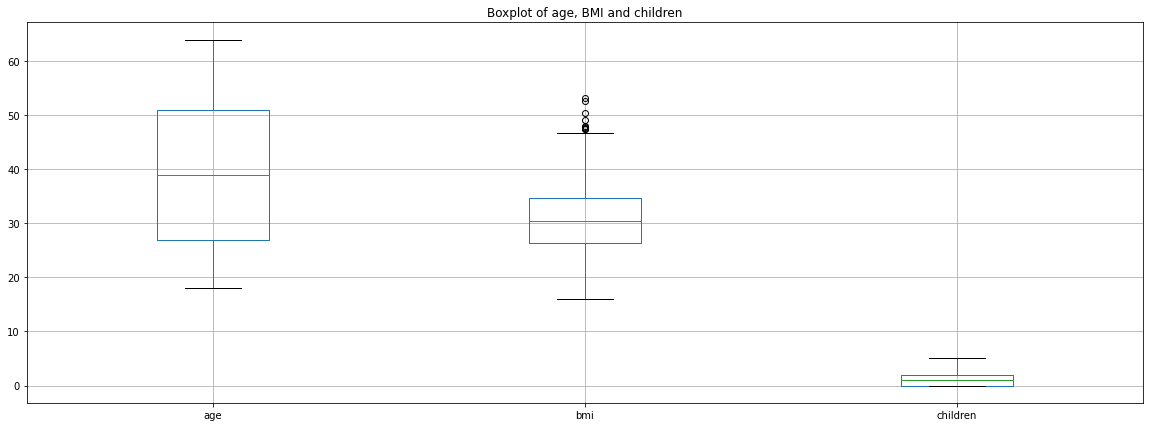

In [9]:
df.drop('insurance_cost', axis=1).boxplot(figsize= (20, 7))
plt.title("Boxplot of age, BMI and children")
plt.show()

The above plot shows that there are a few outliers in `bmi`, but I do not believe these require special treatment as there is a negligible difference between the mean and Q2 value for this attribute.

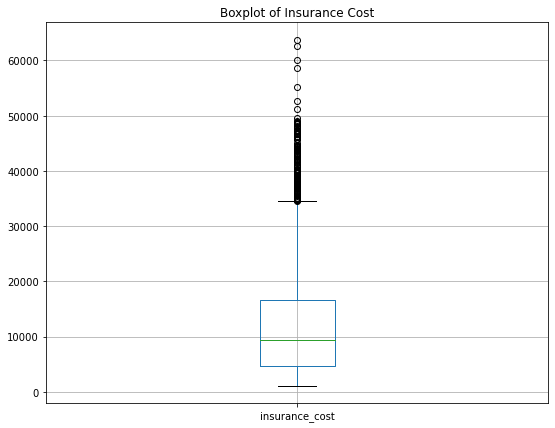

In [10]:
df.boxplot(column=['insurance_cost'], figsize= (9, 7))
plt.title("Boxplot of Insurance Cost")
plt.show()

As hypothesised, `insurance_cost` does have a lot of outliers. However, since this attribute is our `target`, I will not be scaling the data.

I believe that the imbalance in the value counts of `smoker` may be causing this huge skew in `insurance_cost`.

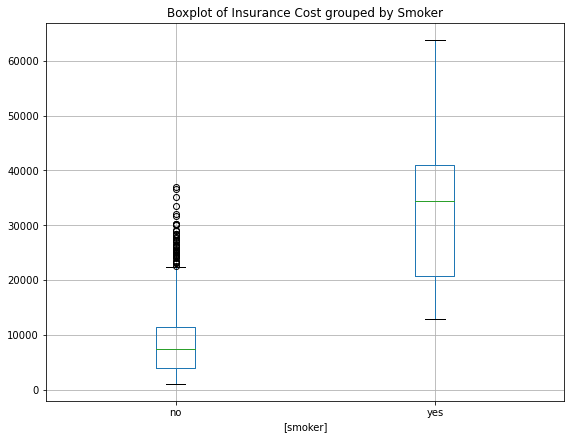

In [12]:
df.boxplot(column=['insurance_cost'],by=['smoker'], figsize= (9, 7))
plt.title("Boxplot of Insurance Cost grouped by Smoker")
plt.suptitle("")
plt.show()

The above plot suggests that my theory is correct. Smokers on average have a far higher insurance cost than nonsmokers, but since there are far fewer smokers than nonsmokers in the dataset it is causing the smoker entries with a high insurance cost to become outliers.

## 3. Data Preparation
I'll begin the data preparation by encoding the categorical attributes. Since neither `gender`, `smoker` nor `region` have an order to follow, one-hot encoding is sufficient to encode these attribtues.

In [13]:
df = pd.get_dummies(df, columns=['gender', 'smoker', 'region'], 
                        #dummy_na=True, 
                        drop_first=True)
df.head()

,age,bmi,children,insurance_cost,gender_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,18,33.770,1,1725.55230,1,0,0,1,0
1,18,34.100,0,1137.01100,1,0,0,1,0
2,18,26.315,0,2198.18985,0,0,0,0,0
3,18,38.665,2,3393.35635,0,0,0,0,0
4,18,35.625,0,2211.13075,0,0,0,0,0


The next step is to scale the data. Since none of the predictors have extreme outliers we only require a StandardScalar. We'll prepare a preprocessing pipeline similar to the pipeline in Etivity 4 to handle this scaling.

In [14]:
# store a list with the names of all predictors
names_all = [c for c in df if c not in ['insurance_cost']]

In [15]:
class AddColumnNames(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return pd.DataFrame(data=X, columns=self.columns)

In [16]:
preprocess_pipeline = make_pipeline(
    AddColumnNames(columns=names_all),
    StandardScaler()
)

Now let's split the data into the predictors and target, and then into testing and training sets.

In [17]:
y = df['insurance_cost']
X = df.drop('insurance_cost', axis=1).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

## 4. Grid Search for Best Parameters and Best Dimensionality Reduction Method
Here we will train a `Random Forest`, `Linear Regression` and `KNN` Regression model with different parameters and different dimensionality reduction methods in order to find the best combination. The dimensionality reduction methods we'll use are:

- Principal Component Analysis (PCA)
- Recursive Feature Elimination (RFE) with estimator `svm.SVR`
- Recursive Feature Elimination (RFE) with estimator `LinearRegression`
- Linear Discriminant Analysis
- Feature Agglomeration

### 4.1 Random Forest
The next step is to train a Random Forest Regressor with the training set and a range of possible parameters and dimensionality reduction methods in order to find the best parameters for RF by cross-validation.

In [18]:
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), 
                       ('reduce_dim', 'passthrough'),
                       ('regresson', RandomForestRegressor(n_estimators=10))])


In [25]:
N_FEATURES_OPTIONS = [2, 6, 11]
MAX_DEPTH_OPTIONS = [2, 4, 6, 8]

param_grid = [
    {
        'reduce_dim': [PCA(iterated_power=7)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'regresson__max_depth': MAX_DEPTH_OPTIONS
    },
    {
        'reduce_dim': [RFE(svm.SVR(kernel='linear', gamma='auto')),RFE(LinearRegression())],
        'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
        'regresson__max_depth': MAX_DEPTH_OPTIONS
    },
    {
        'reduce_dim': [LDA()],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
    },
    {
        'reduce_dim': [FeatureAgglomeration()],
        'reduce_dim__n_clusters': N_FEATURES_OPTIONS,
    }  
]

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)

print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
RF_best_params = search.best_params_
RF_best_model = search.best_estimator_

Best CV score = 0.859:
Best parameters:  {'reduce_dim': RFE(estimator=LinearRegression(), n_features_to_select=11), 'reduce_dim__n_features_to_select': 11, 'regresson__max_depth': 4}


The output from training the `Random Forest Regressor` reveals the best CV score and parameters values.
It also shows us that the best dimensionality method for `Random Forest Regressor` was Recursive Feature Elimination (RFE) with estimator LinearRegression.

### 4.2 Linear Regression
Now let's perform the same steps with a Linear Regression model.

In [27]:
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), 
                       ('reduce_dim', 'passthrough'),
                       ('regresson', LinearRegression())])

In [28]:
N_FEATURES_OPTIONS = [2, 6, 11]
NORMALIZE_OPTIONS = [False, True]

param_grid = [
    {
        'reduce_dim': [PCA(iterated_power=7)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'regresson__normalize': NORMALIZE_OPTIONS
    },
    {
        'reduce_dim': [RFE(svm.SVR(kernel='linear', gamma='auto')),RFE(LinearRegression())],
        'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
        'regresson__normalize': NORMALIZE_OPTIONS
    },
    {
        'reduce_dim': [LDA()],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
    },
    {
        'reduce_dim': [FeatureAgglomeration()],
        'reduce_dim__n_clusters': N_FEATURES_OPTIONS,
    }   
]

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
LR_best_params = search.best_params_
LR_best_model = search.best_estimator_

Best CV score = 0.741:
Best parameters:  {'reduce_dim': RFE(estimator=LinearRegression(), n_features_to_select=6), 'reduce_dim__n_features_to_select': 6, 'regresson__normalize': False}


The output from training the `Linear Regression` reveals the best CV score and parameters values.
It also shows us that the best dimensionality method for `Linear Regression` was Recursive Feature Elimination (RFE) with estimator LinearRegression.

### 4.3 KNN Regressor
Finally, I selected the K-Nearest Neighbours Regressor as my third model. My main reason for this was because I used a KNN Classifier in Etivity 4 and thus have an understanding of how KNN works.

In [30]:
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), 
                       ('reduce_dim', 'passthrough'),
                       ('regresson', KNR())])

In [36]:
N_FEATURES_OPTIONS = [3,4,5,6,7]
MAX_DEPTH_OPTIONS = ["auto",  "ball_tree", "kd_tree", "brute"]

param_grid = [
    {
        'reduce_dim': [PCA(iterated_power=7)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'regresson__algorithm': MAX_DEPTH_OPTIONS
    },
    {
        'reduce_dim': [RFE(svm.SVR(kernel='linear', gamma='auto')),RFE(LinearRegression())],
        'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
        'regresson__algorithm': MAX_DEPTH_OPTIONS
    },
    {
        'reduce_dim': [LDA()],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
    },
    {
        'reduce_dim': [FeatureAgglomeration()],
        'reduce_dim__n_clusters': N_FEATURES_OPTIONS,
    } 
]

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)

print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
KNN_best_params = search.best_params_
KNN_best_model = search.best_estimator_

Best CV score = 0.826:
Best parameters:  {'reduce_dim': RFE(estimator=SVR(gamma='auto', kernel='linear'), n_features_to_select=4), 'reduce_dim__n_features_to_select': 4, 'regresson__algorithm': 'ball_tree'}


The output from training the `KNN Regressor` reveals the best CV score and parameters values.
It also shows us that the best dimensionality method for `KNN Regressor` was Recursive Feature Elimination (RFE) with estimator svm.SVR.

## 5. Compare Regression on a Test Set
After training the models, we can now evaluate their performance on the test data and compare the results using the following metrics:

- mean squared error (MSE)
- mean absolute error (MAE)
- 1-relative squared error (R2)

In [37]:
# model - a trained regression model

def evaluate_model(X_test, y_test, model):
    
    # compute predictiond for the test set
    _predicted_values = model.predict(X_test)
        
    # compute metrics
    _mse = mean_squared_error(y_test, _predicted_values)
    _mae = mean_absolute_error(y_test, _predicted_values)
    _r2 = r2_score(y_test, _predicted_values)
            
    return _mse, _mae, _r2

We can use the above function to evaluate the performance of the three models.

In [38]:
RF_mse, RF_mae, RF_r2 = evaluate_model(X_test, y_test, RF_best_model)
LR_mse, LR_mae, LR_r2 = evaluate_model(X_test, y_test, LR_best_model)
KNN_mse, KNN_mae, KNN_r2 = evaluate_model(X_test, y_test, KNN_best_model)

Next, we'll plot the results so we can compare the performance of the three models.

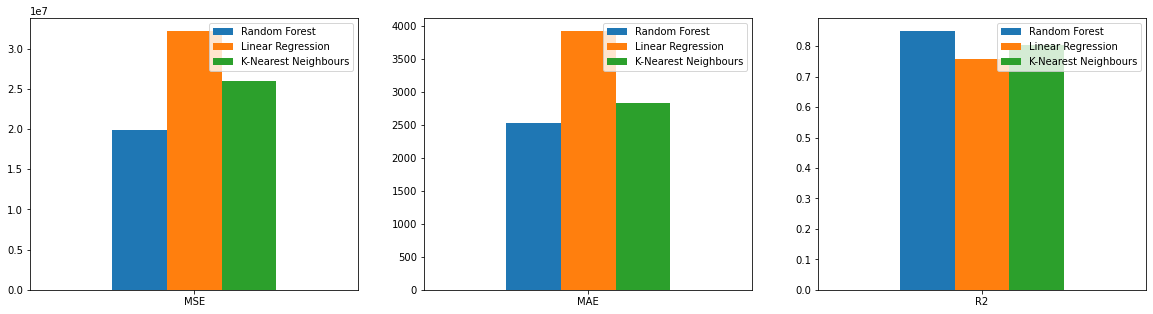

In [39]:
 df_mse = pd.DataFrame({'Random Forest': RF_mse, 'Linear Regression': LR_mse, 'K-Nearest Neighbours':KNN_mse}, index=['MSE'])
df_mae = pd.DataFrame({'Random Forest': RF_mae, 'Linear Regression': LR_mae, 'K-Nearest Neighbours':KNN_mae}, index=['MAE'])
df_r2 = pd.DataFrame({'Random Forest': RF_r2, 'Linear Regression': LR_r2, 'K-Nearest Neighbours':KNN_r2}, index=['R2'])

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))

df_mse.plot.bar(rot=0, ax=axes[0])
df_mae.plot.bar(rot=0, ax=axes[1])
df_r2.plot.bar(rot=0, ax=axes[2])

plt.show()

A quick note before analysing the results: A higher MSE and MAE is considered a bad result since it means there's a higher error rate. However, R2 is a metric for the goodness of fit, thus a higher R2 value means the model is performing well.

The following can be observed from the above plots:
- `Linear Regression` has arguably the worst performance of the three models since its MSE and MAE are far higher than the other two models and it has the lowest R2 value.
- `KNN` has in the middle of the pack. It has the second highest result in each metric.
- `Random Forest` performed noticeably better; it has the lowest MSE and MAE values and the highest R2 value. 

Thus it can be concluded that `Random Forest` has performed better on this dataset than the other models.

## 6. Train a Final Model
The last step is to train the final `Random Forest Regressor` model using the best parameters and dimensionality reduction method discovered in part 4.

In [40]:
# function to remove the string 'regresson__' from the names of the best parameters
def transform(dict, prefix):
    dict_prefix = {key:value for key,value in dict.items() if prefix in key}
    return {key.replace(prefix,''):value for key,value in dict_prefix.items()}

pipe = make_pipeline(preprocess_pipeline, 
                     RF_best_params.get('reduce_dim'),
                     RandomForestRegressor(n_estimators=10, **transform(RF_best_params, 'regresson__')))

final_model =pipe.fit(X, y)

Now we can store the model on disc using Pickle.

In [41]:
filename = 'final_model.sav'
pickle.dump(final_model, open(filename, 'wb'))